In [1]:
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
from CreateDataset import create_dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
from Dataprocessor import filter_data, augment_dataset

In [2]:
x_train, x_test, y_train, y_test, d = create_dataset("data")

In [3]:
x_train.shape, y_train.shape

((5427, 300, 300, 3), (5427, 27))

## Testing Dataprocess

In [4]:
x_train_augmented, y_train_augmented = augment_dataset(x_train, y_train)
x_test_augmented, y_test_augmented = augment_dataset(x_test, y_test)

In [5]:
x_train_filtered, y_train_filtered = filter_data(x_train_augmented, y_train_augmented)
x_test_filtered, y_test_filtered = filter_data(x_test_augmented, y_test_augmented)

In [6]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_filtered)
x_test_scaled = scaler.fit_transform(x_test_filtered)

In [61]:
import joblib
# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [12]:
X_train_tensor = torch.tensor(np.array(x_train_scaled), dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train_filtered), dtype=torch.float32)
X_test_tensor = torch.tensor(np.array(x_test_scaled), dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(y_test_filtered), dtype=torch.float32)

In [13]:
torch.save(X_train_tensor, 'tensors/x_train.pt')
torch.save(X_test_tensor, 'tensors/x_test.pt')
torch.save(y_train_tensor, 'tensors/y_train.pt')
torch.save(y_test_tensor, 'tensors/y_test.pt')

## torch test

In [ ]:
import torch
import torch.nn.functional as F  
import torch.optim as optim
import torch.nn as nn
import matplotlib

In [68]:
import torch.nn.functional as F  # Correct import
class EnhancedHandGestureModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(63, 128)  # Adjust input size (63) for hand coordinates
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0.1)
        
        self.fc3 = nn.Linear(64, 27)  # Output layer for 27 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))  # Apply ReLU after BatchNorm and Linear layer
        x = self.drop1(x)  # Dropout for regularization
        x = self.relu(self.bn2(self.fc2(x)))  # Apply ReLU after BatchNorm and Linear layer
        x = self.drop2(x)  # Dropout for regularization
        x = self.fc3(x)  # Output logits for 27 classes
        return x  # No Softmax required for CrossEntropyLoss

# Initialize model
model = EnhancedHandGestureModel()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

# Loss function (criterion)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification

# Assuming you have:
# X_train_tensor, y_train_tensor (training data)
# X_val_tensor, y_val_tensor (validation data)
# X_test_tensor, y_test_tensor (test data - not used during training)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
no_improve = 0

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_test_tensor)  # Use validation set, not test set
        val_loss = criterion(val_output, y_test_tensor)
    
    scheduler.step(val_loss)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        no_improve += 1
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
        
    if no_improve >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor)
    _, predicted = torch.max(test_output, 1)
    y_test_indices = torch.argmax(y_test_tensor, dim=1)
    accuracy = (predicted == y_test_indices).float().mean()
    
print(f'Test Loss: {test_loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch 0: Train Loss: 3.3920, Val Loss: 3.3004
Epoch 10: Train Loss: 2.4190, Val Loss: 3.2072
Epoch 20: Train Loss: 1.9469, Val Loss: 2.9161
Epoch 30: Train Loss: 1.6143, Val Loss: 2.4259
Epoch 40: Train Loss: 1.3602, Val Loss: 1.8130
Epoch 50: Train Loss: 1.1665, Val Loss: 1.3353
Epoch 60: Train Loss: 1.0190, Val Loss: 1.0784
Epoch 70: Train Loss: 0.8961, Val Loss: 0.9369
Epoch 80: Train Loss: 0.7984, Val Loss: 0.8529
Epoch 90: Train Loss: 0.7141, Val Loss: 0.7842
Epoch 100: Train Loss: 0.6443, Val Loss: 0.7272
Epoch 110: Train Loss: 0.5834, Val Loss: 0.6745
Epoch 120: Train Loss: 0.5335, Val Loss: 0.6273
Epoch 130: Train Loss: 0.4869, Val Loss: 0.5853
Epoch 140: Train Loss: 0.4486, Val Loss: 0.5411
Epoch 150: Train Loss: 0.4095, Val Loss: 0.5022
Epoch 160: Train Loss: 0.3743, Val Loss: 0.4713
Epoch 170: Train Loss: 0.3438, Val Loss: 0.4418
Epoch 180: Train Loss: 0.3162, Val Loss: 0.4286
Epoch 190: Train Loss: 0.2916, Val Loss: 0.4190
Epoch 200: Train Loss: 0.2711, Val Loss: 0.4166
Ear

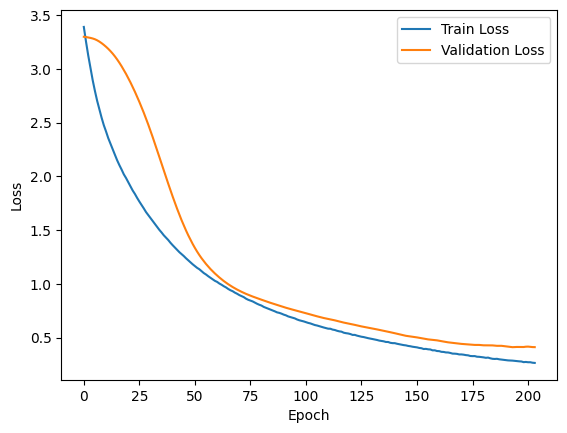

In [69]:
import matplotlib.pyplot as plt

# After training loop
# Plotting training and validation loss
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import cv2
import mediapipe as mp
import torch
import joblib  # Assuming you saved the scaler using joblib

# Initialize the model
model = EnhancedHandGestureModel()

# Load the state dictionary (the saved model weights)
state_dict = torch.load("best_model.pth")

# Load the state dictionary into the model
model.load_state_dict(state_dict)
model.eval()

# Load the scaler
scaler = joblib.load("scaler.pkl")  # Adjust path as necessary

# Initialize MediaPipe Hands module
cap = cv2.VideoCapture(0)
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

# Define the mapping for 27 classes
class_map = ['Blank'] + [chr(i) for i in range(ord('A'), ord('Z')+1)]  # Blank + A-Z

def map_class_to_letter(predicted_class):
    """ Map the predicted class index to a letter or blank """
    return class_map[predicted_class]

def predict_gesture(landmarks):
    """ Normalize landmarks and run prediction with the model """
    # Convert landmarks into a 63-dimensional vector (flattened)
    hand_coords = []
    for lm in landmarks:
        hand_coords.append(lm.x)
        hand_coords.append(lm.y)
        hand_coords.append(lm.z)

    # Convert to a 2D array and apply scaling
    # hand_coords = [hand_coords]  # Convert to 2D array with shape (1, 63)
    # hand_coords = scaler.transform(hand_coords)  # Normalize the coordinates
    
    # Convert to a torch tensor
    input_tensor = torch.tensor(hand_coords, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    
    # Get model output
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)  # Get predicted class
    return predicted.item()  # Return the predicted class

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break

    # Flip the frame to make it a mirror view
    frame = cv2.flip(frame, 1)

    # Convert the image to RGB (MediaPipe works with RGB images)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        for landmarks in result.multi_hand_landmarks:
            # Draw hand landmarks
            mp.solutions.drawing_utils.draw_landmarks(frame, landmarks, mp_hands.HAND_CONNECTIONS)

            # Extract landmarks and make predictions
            predicted_class = predict_gesture(landmarks.landmark)
            # Map predicted class index to gesture label
            predicted_gesture = map_class_to_letter(predicted_class)

            # Display the predicted gesture on the frame
            cv2.putText(frame, f"Gesture: {predicted_gesture}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow("Hand Gesture Recognition", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


[0.2683008909225464, 0.7445898056030273, -3.9214523894770537e-07, 0.2704775333404541, 0.6892369389533997, 0.01778649538755417, 0.2936280369758606, 0.655677080154419, 0.0222017802298069, 0.3190007507801056, 0.6499975919723511, 0.018760008737444878, 0.34132254123687744, 0.6603074669837952, 0.013695484958589077, 0.29791873693466187, 0.6216279864311218, 0.025605306029319763, 0.3305661976337433, 0.6434872150421143, 0.02477836236357689, 0.33791685104370117, 0.6765123009681702, 0.020137140527367592, 0.3348507285118103, 0.7007576823234558, 0.01816350221633911, 0.3203170597553253, 0.6212213635444641, 0.01169596053659916, 0.3585611879825592, 0.6581874489784241, 0.013504129834473133, 0.36037611961364746, 0.6955893635749817, 0.006677605677396059, 0.3516566753387451, 0.718183696269989, 0.002257085172459483, 0.34240201115608215, 0.6353278756141663, -0.0011799110798165202, 0.38405001163482666, 0.6584221720695496, -0.0023972957860678434, 0.38377144932746887, 0.6986619830131531, -0.0062312171794474125,